
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42)

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы построим дерево решений с нуля. Данное задание не является обязательным к выполнению, и больше направлена на ваш персональный интерес к тематике. За выполнение данного задания вы можете получить дополнительные баллы 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1Hyt4ZBH6T4o-qVHxuzdFQ9p-WaSiCr_ia2EcMxatKsg/edit?usp=sharing).**


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz as gv
import matplotlib as mpl

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз , а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно пройдитесь по ноутбуку в разделе практики по деревьям решений. 

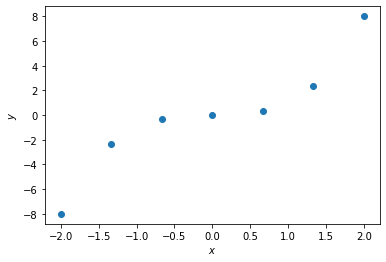

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

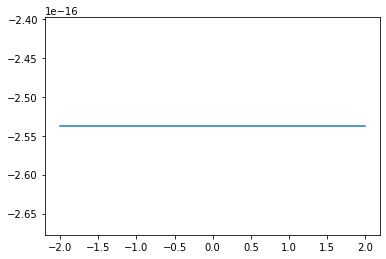

In [3]:
denseSet = np.arange(-2, 2, step = 0.01)
predicted = np.array([np.average(y) for x in denseSet])
plt.plot(denseSet, predicted)

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

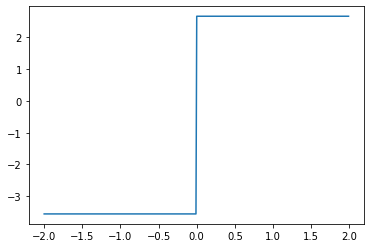

In [4]:
denseSet = np.arange(-2, 2, step = 0.01)
predicted = np.array([np.average(y, weights = (X < 0 if x < 0 else X >= 0)) for x in denseSet])
plt.plot(denseSet, predicted)

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [5]:
def regression_var_criterion(X, y, t):
    
    def D(X, y):
        sub = y.sum() / X.size
        result = 0
        for yi in y:
            result += (yi - sub) ** 2
        result /= X.size
        return result
    
    Xl = X[X < t]
    yl = y[X < t]
    Xr = X[X >= t]
    yr = y[X >= t]
    result = D(X, y) - Xl.size / X.size * D(Xl, yl) - Xr.size / X.size * D(Xr, yr)
    return result

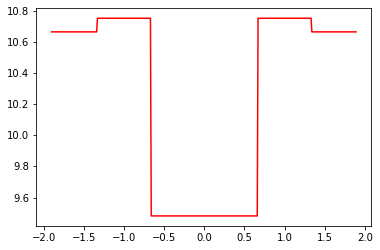

In [6]:
ts = np.arange(-1.9, 1.9, step = 0.01)
qs = np.array([regression_var_criterion(X, y, t) for t in ts])
plt.plot(ts, qs, 'r')

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет <---

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

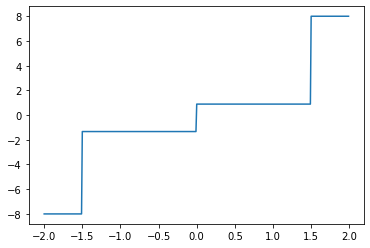

In [7]:
def predict(trainX, trainY, x):
    curX = trainX
    curY = trainY
    
    goLeft = curX < 0
    if x < 0:
        curX = curX[goLeft]
        curY = curY[goLeft]
        
        goLeft = curX < -1.5
        if x < -1.5:
            curX = curX[goLeft]
            curY = curY[goLeft]
        else:
            curX = curX[~goLeft]
            curY = curY[~goLeft]
        
    else:
        curX = curX[~goLeft]
        curY = curY[~goLeft]
        
        goLeft = curX < 1.5
        if x < 1.5:
            curX = curX[goLeft]
            curY = curY[goLeft]
        else:
            curX = curX[~goLeft]
            curY = curY[~goLeft]
            
    return curY.mean()

denseSet = np.arange(-2, 2, step = 0.01)
predicted = np.array([predict(X, y, xi) for xi in denseSet])
plt.plot(denseSet, predicted)

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7 <---
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [8]:
df = pd.read_csv('../../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')
df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
99996,19066,2,183,105.0,180,90,3,1,0,1,0,1


In [9]:
for feature in ['cholesterol', 'gluc']:
    print('{0} values: {1}'.format(feature, np.sort(df[feature].unique())))

cholesterol values: [1 2 3]
gluc values: [1 2 3]


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [10]:
df = pd.get_dummies(df, columns = ['cholesterol', 'gluc'])
df

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,2,168,76.0,120,80,1,0,1,0,1,0,0,1,0,0
99995,22601,1,158,126.0,140,90,0,0,1,1,0,1,0,0,1,0
99996,19066,2,183,105.0,180,90,0,1,0,1,0,0,1,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [11]:
X = df.drop('cardio', axis = 1)
y = df['cardio']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.7, random_state = 17)
display(X_train)
display(y_train)
display(X_valid)
display(y_valid)

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,
30908,18243,2,169,76.0,160,80,0,0,1,1,0,0,1,0,0
86475,17445,2,158,68.0,140,90,1,0,1,1,0,0,1,0,0
77291,22645,1,165,70.0,120,80,0,0,1,1,0,0,0,1,0
63162,16778,1,140,70.0,140,90,0,0,0,1,0,0,1,0,0
43647,17606,2,172,101.0,120,80,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53319,21822,2,178,85.0,140,80,1,0,0,0,1,0,1,0,0
36581,20428,2,164,57.0,120,70,0,0,1,1,0,0,1,0,0
60428,16740,1,163,77.0,90,60,0,0,1,1,0,0,1,0,0


id
30908    1
86475    1
77291    1
63162    1
43647    0
        ..
53319    1
36581    1
60428    0
49936    0
92425    0
Name: cardio, Length: 49000, dtype: int64

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,
5566,21089,2,165,72.0,120,80,0,0,1,1,0,0,1,0,0
20293,21945,2,175,80.0,120,70,0,0,1,1,0,0,1,0,0
40253,22509,2,166,64.0,150,90,0,0,1,1,0,0,1,0,0
79294,19762,1,168,70.0,110,80,1,0,1,1,0,0,1,0,0
87847,21032,1,175,87.0,140,70,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95101,19146,1,168,77.0,110,80,0,1,1,1,0,0,1,0,0
14351,19109,1,164,80.0,140,80,0,0,0,0,1,0,1,0,0
49834,23153,1,160,68.0,150,1000,0,0,1,0,1,0,0,1,0


id
5566     0
20293    0
40253    0
79294    0
87847    0
        ..
95101    0
14351    1
49834    1
66558    1
77786    1
Name: cardio, Length: 21000, dtype: int64

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [12]:
def showImage(filePath):
    dpi = mpl.rcParams['figure.dpi']
    image = plt.imread(filePath)
    height, width, depth = image.shape
    figsize = (width / float(dpi), height / float(dpi))
    fig = plt.figure(figsize = figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    imagePlot = ax.imshow(image)
    ax.axis('off')
    plt.show()
    
def showTreeImage(tree, filename, features):
    dotFileName = filename + '.dot'
    export_graphviz(tree, feature_names = features, out_file = dotFileName, filled = True)
    pngFileName = gv.render('dot', 'png', dotFileName)
    showImage(pngFileName)

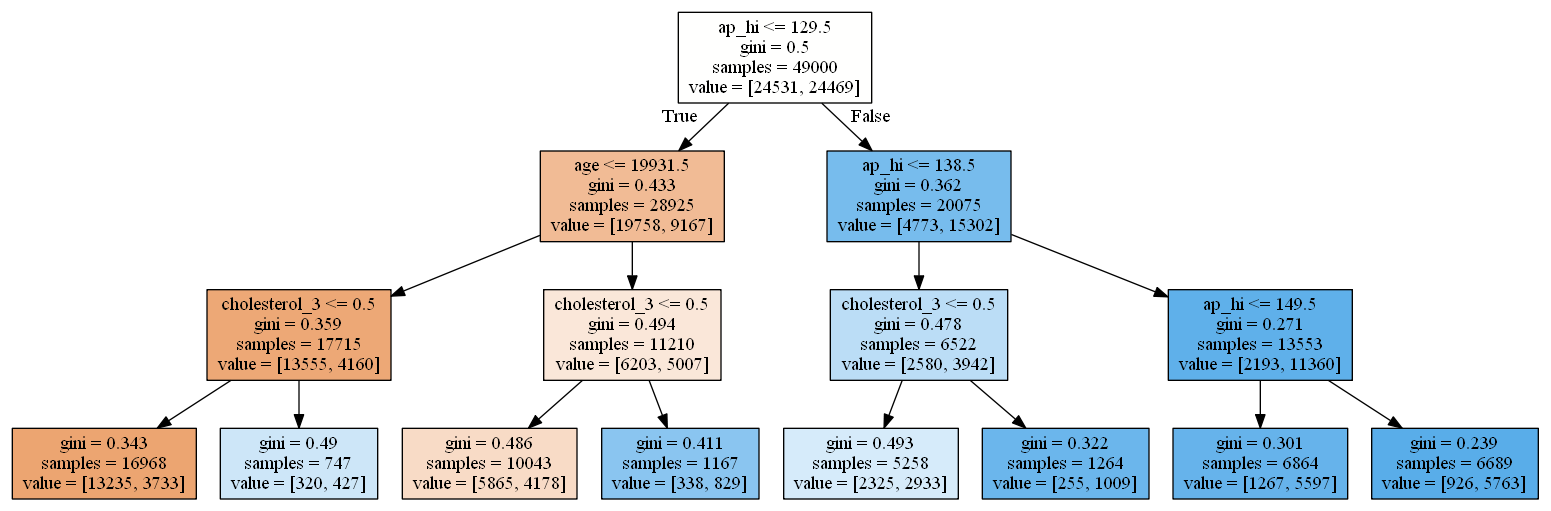

In [15]:
decisionTree = DecisionTreeClassifier(max_depth = 3, random_state = 17)
decisionTree.fit(X_train, y_train)
showTreeImage(decisionTree, 'hw3tree', X.columns)

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3 <---

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [16]:
accuracy1 = decisionTree.score(X_valid, y_valid)
print('accuracy: {0}'.format(accuracy1))

accuracy: 0.7212857142857143


Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [18]:
tree_params = {'max_depth': list(range(2, 11))}

decisionTree = DecisionTreeClassifier(max_depth = 3, random_state = 17)
tree_grid = GridSearchCV(decisionTree, tree_params, cv = 5, n_jobs = -1, verbose = True)
tree_grid.fit(X_train, y_train)
print('best parameters: {0}'.format(tree_grid.best_params_))
print('best score: {0}'.format(tree_grid.best_score_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    1.5s remaining:    0.2s


best parameters: {'max_depth': 6}
best score: 0.731938775510204


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

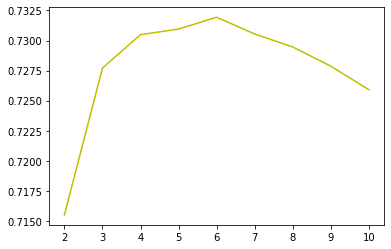

In [19]:
depths = np.array([params['max_depth'] for params in tree_grid.cv_results_['params']])
scores = np.array(tree_grid.cv_results_['mean_test_score'])
plt.plot(depths, scores, 'y')

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [20]:
bestDepth = depths[scores == scores.max()][0]
print('best depth is {0}'.format(bestDepth))
accuracy2 = tree_grid.best_estimator_.score(X_valid, y_valid)
print('accuracy is {0:.3f}% (changed by {1:.3f}%)'.format(100 * accuracy2, 100 * (accuracy2 - accuracy1) / accuracy1))

best depth is 6
accuracy is 72.581% (changed by 0.627%)


**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет <---
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.) <---
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [21]:
df = pd.read_csv('../../../data/mlbootcamp5_train.csv', index_col = 'id', sep = ';')
df = pd.get_dummies(df, columns = ['cholesterol'])
df['gender'] -= 1
df.rename(columns = {'gender': 'male'}, inplace = True)
df['age'] = df['age'] / 365.25

def differentiate(feature, bounds):
    for lb, ub in zip(bounds[:-1], bounds[1:]):
        newFeature = '{0}_{1}_{2}'.format(feature, lb, ub)
        df[newFeature] = ((df[feature] >= lb) & (df[feature] < ub)).astype(int)
    df.drop(feature, axis = 1, inplace = True)
    
df.drop(['height', 'weight', 'ap_lo', 'gluc', 'active', 'alco'], axis = 1, inplace = True)
    
differentiate('age', [45, 50, 55, 60, 65])
differentiate('ap_hi', [120, 140, 160, 180])
    
df

,male,smoke,cardio,cholesterol_1,cholesterol_2,cholesterol_3,age_45_50,age_50_55,age_55_60,age_60_65,ap_hi_120_140,ap_hi_140_160,ap_hi_160_180
id,,,,,,,,,,,,,
0,1,0,0,1,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,1,0,0,1,0,0,1,0
2,0,0,1,0,0,1,0,1,0,0,1,0,0
3,1,0,1,1,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,1,1,0,1,0,0,0,1,0,0,1,0,0
99995,0,0,1,0,1,0,0,0,0,1,0,1,0
99996,1,0,1,0,0,1,0,1,0,0,0,0,0


In [22]:
X = df.drop('cardio', axis = 1)
y = df['cardio']

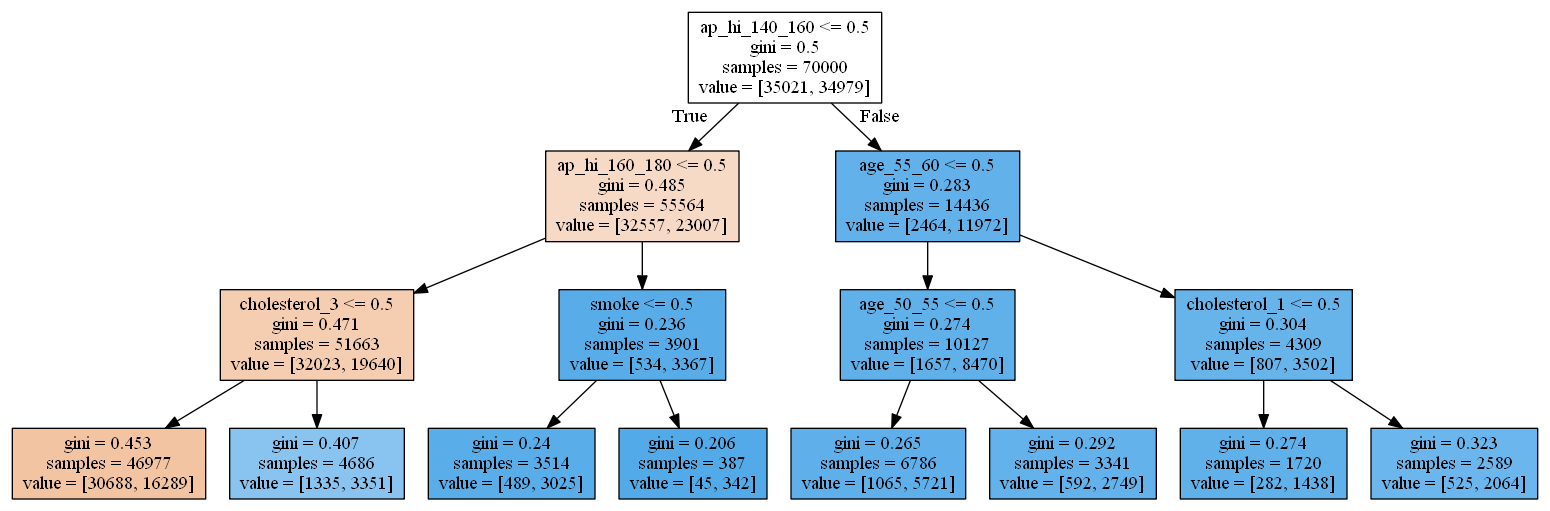

In [23]:
decisionTree = DecisionTreeClassifier(max_depth = 3, random_state = 17)
decisionTree.fit(X, y)
showTreeImage(decisionTree, 'hw3tree2', X.columns)